In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.io import fits
from scipy.ndimage import zoom
import stl

In [2]:
def scale_pupil(pupil, output_size):
    """
    Takes in the complex pupil array and returns a scaled version
    
    BUGS: 
    This does not work correctly on pupils with the side lobe gratings
    
    Inputs:
        pupil: 2D Complex np array of the phase pupil
        output_size: Size of the pupil array to be returned
        
    Returns:
        pupil_scaled: 2D Complex np array of the pupil in the dimension of output_size X output_size
    """
    # Scale the real component of the pupil to this size
    size_in = pupil.shape[0]
    ratio = output_size/size_in    
    Re_scaled = zoom(pupil.real, ratio)
    
    # Create the new pupil from a real and imaginary component
    pupil_scaled = Re_scaled + np.zeros([output_size, output_size]) * 1j
    
    # Create the masks to fix the values of the pupil
    norm_phase = np.logical_and(np.abs(pupil_scaled) != 0, np.angle(pupil_scaled) == 0)
    anti_phase = np.logical_and(np.abs(pupil_scaled) != 0, 
                                np.logical_or(np.angle(pupil_scaled) == np.pi, np.angle(pupil_scaled) == -np.pi))
    c = output_size//2
    s = np.linspace(-c, c, num=output_size, endpoint=False)
    X,Y = np.meshgrid(s, s)
    R = np.hypot(X,Y)
    
    # Assign the correct values to the new array
    pupil_scaled[norm_phase] = np.complex(1, 0)
    pupil_scaled[anti_phase] = np.complex(-1, 0)
    pupil_scaled[R >= c-1] = np.complex(0, 0)
    
    return pupil_scaled

def pupil_from_fits(file_name):
    """
    Takes in the fits file and returns a complex array of the pupil
    """
    # Create a fits object from astropy
    fits_file = fits.open(file_name)[0].data
    array = np.array(fits_file)

    # Calculate needed values
    gridsize = array.shape[0]
    c = gridsize//2
    
    # Create value arrays
    Xs = np.linspace(-c, c-1, num=gridsize)
    X, Y = np.meshgrid(Xs, Xs)
    r = np.hypot(X, Y)
    
    # Create pupil
    pupil = np.exp(1j*array)
    
    # Zero outer regions
    pupil[r >= (gridsize//2)] = np.complex(0,0)
        
    return pupil

def phase_to_depth(comp_array, wl, n1, n2):
    """
    Converts a phase value (0, pi) to a depth for a specified wavelength
    """
    depth_array = (np.angle(comp_array) * wl) / (2 * np.pi * (n2 - n1))
    return depth_array

def mesh_to_stl(X, Y, Z, N, file_name, unit_in='m', unit_out='mm', binary=True):
    """
    Inputs:
        X: 2D numpy array of values defining the x position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        X = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
                                ...
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
             [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]

        Y: 2D numpy array of values defining the y position of each pixel
        ie for a 1x1m sized mesh object with a 0.1m resolution we expect
        Y = [[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
             [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
                                ...
             [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
             [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]

        Z: 2D numpy array of values defining the z position (height) of each pixel
        using plt.imshow(Z) should yeild a 'surface map' type image

        N: The number of pixels in the array, ie X, Y, Z should all be NxN

        file_name: The path/name of the file name to save under

        unit_in: The input units of the X, Y, Z arrays. Default is meters.
        Can be 'm', 'mm', 'um', 'nm'

        unit_out: The output units of the stl file. ie for a 1x1m sized mesh object
        with units in mm we expect the X, Y output to range from 0 to 900. Default
        is milimeters. Can be 'm', 'mm', 'um', 'nm'

        binary: If True file will be output as binary (smaller), else ASCII (readable)
        
    Output:
        returns None, saves an stl file to disk
    
    -------------------------------------------------------------------
    Algorithm:
        Method: Decompose the traversal pattern into a series of simpler patters
        and combine them to get the final pattern.

        For a gridsize of N, we have N-1 squares in each row/column, giving a 
        total of (N-1)^2 sqaures and 2*(N-1)^2 triangles

        Each triangle is composed of three points and a so a square is made of 6 points

        Within the series of points there is a repeating pattern which can be 
        decomposed into thee different sequences and combines

        S1: [0,0,0], [1,1,1], [1,1,1], [2,2,2], [2,2,2], [3,3,3], ... 
        S2: [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], [0,0,1], ...
        S3: [N,N,N], [0,0,0], [N,N,N], [0,0,0], [N,N,N], [0,0,0], ...
        Combining these together gives us our repeating pattern, S = S1 + S2 + S3

        Note: These brackes are there to help define the repeating sequence and
        do not relate to the final grouping into triangles.

        The final sequence is then [0, 1, S, N-1] and represents a full row of triangles
        This final sequence is then repeated again with N added to each value, then
        again with 2*N added to each value and so on.
    """
    
    # Dictionary of indexes for scaling values
    dic = {
        'm': 0,
        'mm': 1,
        'um': 2,
        'nm': 3,
    }
    
    # Array of relevant scaling values
    # X axis is unit in, Y axis is unit out
    scale_arr = [[1, 1e-3, 1e-6, 1e-9],
                 [1e3, 1, 1e-3, 1e-6],
                 [1e6, 1e3, 1, 1e-3],
                 [1e9, 1e6, 1e3, 1]]
    
    points = np.array([X.flatten(), Y.flatten(), Z.flatten()]) * scale_arr[dic[unit_out]][dic[unit_in]]

    # Other Numer of trianges and squares
    squares_per_row = N-1 
    triangles_per_row = 2 * squares_per_row
    num_squares = squares_per_row**2
    num_triangles = 2*num_squares

    # Points per triangle and square
    points_per_triangle = 3
    points_per_square = 2 * points_per_triangle

    # Number of points per row
    points_per_row = squares_per_row * points_per_square

    # Size of the sequences
    sequence_size = points_per_row - 3
    full_sequence_size = sequence_size + 3

    # Create indexes used to create sequences
    i = np.linspace(0, sequence_size, num=sequence_size, endpoint=False)
    j = np.floor_divide(i, 3)

    # Sequence 1
    S1 = np.floor_divide(j+1, 2)

    # Sequence 2
    S2_mask = (i+1)%3 == 0
    S2 = np.ones(sequence_size)*S2_mask

    # Sequence 3
    S3_mask = j%2 == 0
    S3 = N*np.ones(sequence_size)*S3_mask

    # Add together
    S = S1 + S2 + S3

    # Non repeating start and end of array
    start = np.array([0, 1])
    end = np.array([squares_per_row])

    # Combine
    sequence = np.concatenate([start, S, end])
    base_sequence = np.tile(sequence, reps=squares_per_row)

    # Create meshgrid of integer N values for the different rows
    arr_x = np.linspace(0, full_sequence_size, num=full_sequence_size, endpoint=False)
    arr_y = np.linspace(0, squares_per_row, num=squares_per_row, endpoint=False)
    X, Y = np.meshgrid(arr_x, arr_y)
    incremental_sequence = N*Y.flatten() # Flatten here in order to combine

    # Combine sequences together to create final array
    full_sequence_flat = base_sequence + incremental_sequence
    full_sequence = full_sequence_flat.reshape([num_triangles,3])

    # Force integer values
    full_sequence = np.array(full_sequence, dtype=np.int64())

    # Create the vertices and points arrays
    vertices = points.T
    faces = full_sequence

    # Create the mesh object
    grid_mesh = stl.mesh.Mesh(np.zeros(faces.shape[0], dtype=stl.mesh.Mesh.dtype))

    # input mesh vectors
    for i, f in enumerate(faces):
        for j in range(3):
            grid_mesh.vectors[i][j] = vertices[f[j],:]
            
    # Write the mesh to file
    if binary:
        grid_mesh.save('{}.stl'.format(file_name))
    else:
        grid_mesh.save('{}.stl'.format(file_name), mode=stl.Mode.ASCII)

In [3]:
# All input units are SI

# The maximum dimension of the pattern, ie aperture
size = 20e-3 # 20mm

# Number of pixels used to describe the surface
# Ie represent array on an NxN grid
# N = 800
N = 2000

# Sinusoidal grating amplitude (peak to trough)
ampl = 100e-9 # 100nm

# Sinusoidal grating period
period = 100e-6 # 100 microns

# Target wavelength where we get perfect antiphase
wl = 635e-9 # 635nm

# Substrate refractive index
n2 = 1.455 # unitless

# Path to the file containing the pupil
file_name = "pupil.fits"

In [9]:
resolution = size/N
print("Resolution is {}mm".format(resolution*1e3))

# Import and scale pupil
native_pupil = pupil_from_fits(file_name)
ratio = N/native_pupil.shape[0]
pupil = scale_pupil(native_pupil, N)

# Create meshgrid for sinusoids
Xs = np.linspace(0, size, num=pupil.shape[0], endpoint=False)
X, Y = np.meshgrid(Xs, Xs)

# Define the sine argument value to get the correct period
B = 2*np.pi / period

# Creating gratings
grating = (ampl*np.sin(B*Y) + ampl*np.sin(B*X))/4
anti_grating = (ampl*np.sin(B*Y + np.pi) + ampl*np.sin(B*X + np.pi))/4

# Create masks to apply gratings
outer = np.abs(pupil) == 0
norm_phase = np.logical_and(np.abs(pupil) != 0, np.angle(pupil) == 0)
anti_phase = np.logical_and(np.abs(pupil) != 0, 
            np.logical_or(np.angle(pupil) == np.pi, np.angle(pupil) == -np.pi))
# Note here we divide the output by 4: 
# ampl is a peak to trough value so we must halve the output once
# To get orthogonal sine waves we sum two seperate 1D sine patterns
# so the amplitude is doubled so we must halve again

# Create array of real Z values
pupil_depth = phase_to_depth(pupil, wl, 1, n2)
Z = np.array(((pupil_depth + grating) * norm_phase + (pupil_depth + anti_grating) * anti_phase))

Resolution is 0.01mm


In [10]:
unit_out = 'mm'
mesh_to_stl(X, Y, Z, N, 'Toliman_{:.0f}_{}'.format(resolution*1e6, unit_out), unit_in='m', unit_out=unit_out, binary=True)

unit_out = 'um'
mesh_to_stl(X, Y, Z, N, 'Toliman_{:.0f}_{}'.format(resolution*1e6, unit_out), unit_in='m', unit_out=unit_out, binary=True)

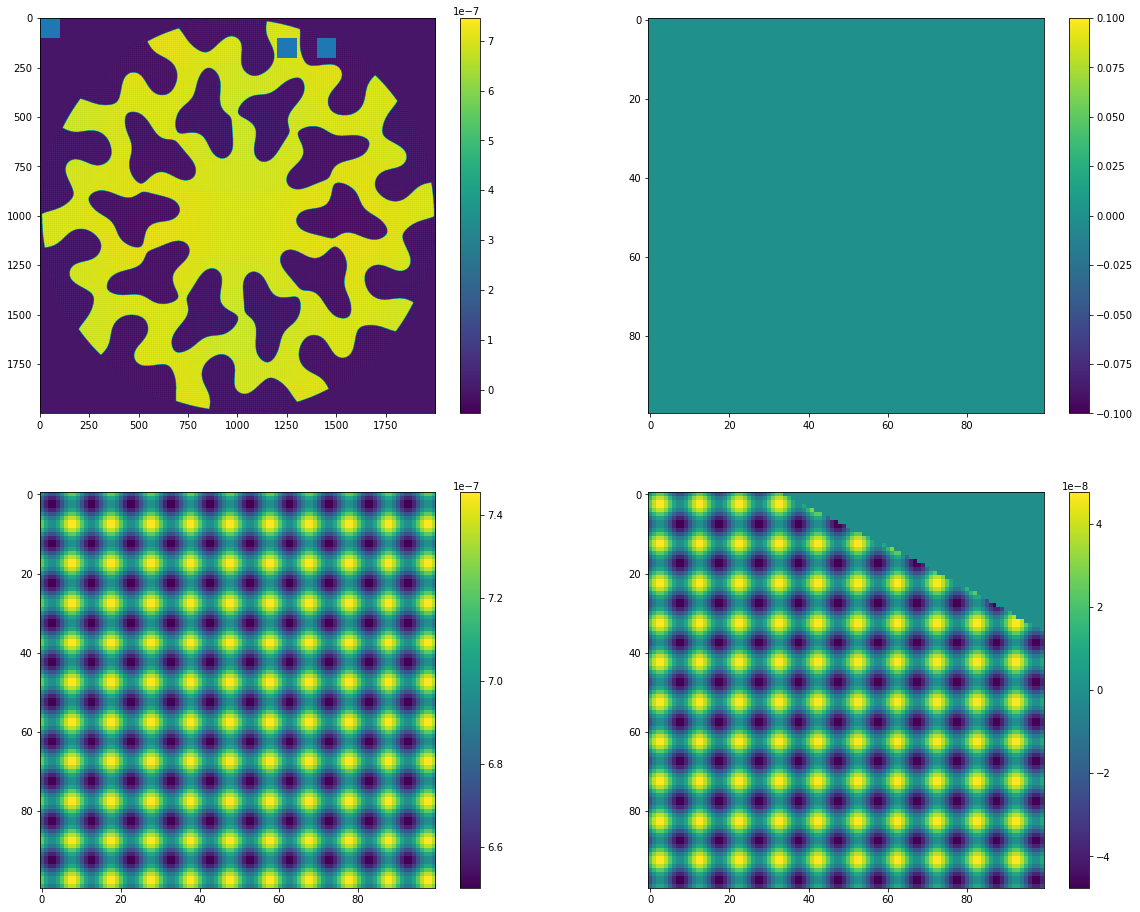

In [11]:
# Check that Z is what we expect

# Plot is of the whole pupil, and 3 different sub regions to get appropriate color scaling 
# in order to see the grating. The bottom two images are offset such the the gratings
# in each image should be in antiphase with each other

size = int(200 * ratio)

x1 = 0
y1 = 0
cut_1 = Z[y1:y1+size, x1:x1+size]

x2 = int(2400 * ratio)
y2 = int(200 * ratio)
cut_2 = Z[y2:y2+size, x2:x2+size]

x3 = int(2800 * ratio)
y3 = int(200 * ratio)
cut_3 = Z[y3:y3+size, x3:x3+size]

plt.figure(figsize=(20,16))

ax = plt.subplot(2,2,1)
plt.imshow(Z)
ax.add_patch(patches.Rectangle((x1, y1), size, size))
ax.add_patch(patches.Rectangle((x2, y2), size, size))
ax.add_patch(patches.Rectangle((x3, y3), size, size))
plt.colorbar()


plt.subplot(2,2,2)
plt.imshow(cut_1)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(cut_2)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(cut_3)
plt.colorbar()
plt.show()